In [ ]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
from shutil import copy, rmtree
import matplotlib
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys, logging
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D

if "__file__" not in dir():

    root='/data'

    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommunNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommunNoteBookesPath)   
    %run Animal_Tags.ipynb
    %run UtilityTools.ipynb
    %run BatchRatBehavior.ipynb
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run Animal_Tags.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb

    os.chdir(CWD)

    defaultParam={
        "binSize":0.25,
        "trialOffset":20., #max end of trial, in seconds (position will be cutted)
        "sigmaSmoothPosition":0.1,  #smooth the position
        #"sigmaSmoothPosition":0.33 for pavel dataType
        "sigmaSmoothSpeed":0.3, #smooth the speed
        "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                      #min to correct start, max to correct jumps
        "pawFrequencyRange":[2.,10.],
        "startAnalysisParams":[10,0.2,0.5],
        "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
        "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked

        #parameter to detect end of trial (first position minima)
        "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
        "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
        "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
        }
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 15}

In [ ]:
class HistologyExcel(ReadExcelFile):

    def __init__(self,*args,**kwargs):
#         assert "fileName" in kwargs, "Specify the path to the histology excel"
#         assert kwargs['fileName'].endswith(("_hist.xlsx","_hist.xls")), "Invalid histology excel path"
        super().__init__(*args,**kwargs)
#         self.check_structure()
        self.df=self.excelData['lesionData']
        self.feed=self.excelData['settings'].axes[1][1]
        
        self.dic={
                  '1ROI_lesion':         {'A':0,'X':12,'Y':24},
                  '1ROI_total':          {'A':1,'X':13,'Y':25},
                  '1Off-ROI_lesion':     {'A':2,'X':14,'Y':26},
                  '1Ventricule':         {'A':3,'X':15,'Y':27},
                  '1Hemisphere':         {'A':4,'X':16,'Y':28},
                  '2ROI_lesion':         {'A':5,'X':17,'Y':29},
                  '2ROI_total':          {'A':6,'X':18,'Y':30},
                  '2Off-ROI_lesion':     {'A':7,'X':19,'Y':31},
                  '2Ventricule':         {'A':8,'X':20,'Y':32},
                  '2Hemisphere':         {'A':9,'X':21,'Y':33}
                 }
    
    def check_structure(self):
        assert self.excelData['lesionData'].iloc[4][0]=='1Hemisphere'
        assert self.excelData['lesionData'].iloc[11][0]=='X'
        assert self.excelData['lesionData'].iloc[23][0]=='Y'
        assert self.excelData['settings'].axes[1][0]=='feed', 'feed was not found'
        
    def measure_vol(self,key):
        """
        This function generalizes the lesion_vol methods
        to measure the volume of any key input
        This function calculates the volume by assuming area  to be circular, 
        using a series of truncated cone volumes.
        """
        idx=self.dic[key]['A']
        vol=[]
        validCol=self.df.axes[1].isin(range(100))
        for i,(sec1,sec2) in enumerate(zip(self.df.axes[1][validCol][:-1],self.df.axes[1][validCol][1:])):
            h=(sec2-sec1)*self.feed
            r1=np.sqrt(self.df.iloc[idx][i+1]/np.pi)
            r2=np.sqrt(self.df.iloc[idx][i+2]/np.pi)
            vol.append(h*(r1**2+r1*r2+r2**2))
                
        return vol
        
    def lesioned_vol(self):
        volLesion=self.measure_vol('1ROI_lesion')
        volLesion.extend(self.measure_vol('2ROI_lesion'))
        volTotal=self.measure_vol('1ROI_total')
        volTotal.extend(self.measure_vol('2ROI_total'))

        return volLesion,volTotal
    
    def lesion_size(self):
        volLesion,volTotal=self.lesioned_vol()
        return np.nanmedian(volLesion)/np.nanmedian(volTotal)
    
    def off_lesioned_vol(self):
        """
        this method returns the total off-target lesioned volume
        """
        volLesion=self.measure_vol('1Off-ROI_lesion')
        volLesion.extend(self.measure_vol('2Off-ROI_lesion'))
        return np.nanmedian(volLesion)

    def lesion_normal_centeroid(self,key='X'):
        assert key in ('X','Y'), "Wrong key"
        
        lesion1= self.dic['1ROI_lesion'][key] #left
        lesion2= self.dic['2ROI_lesion'][key] #right
        str1   = self.dic['1ROI_total'] [key]
        str2   = self.dic['2ROI_total'] [key]
        hemi1  = self.dic['1Hemisphere'][key]
        hemi2  = self.dic['2Hemisphere'][key]
        
        cent_left= []
        cent_right=[]
        validCol=self.df.axes[1].isin(range(100))
        for col in np.where(validCol)[0]:
            midline=np.mean([self.df.iloc[hemi1][col],self.df.iloc[hemi2][col]])
            
            cent_left.append (-(self.df.iloc[lesion1][col]-self.df.iloc[str1][col])  \
                              /midline)
            
            cent_right.append(+(self.df.iloc[lesion2][col]-self.df.iloc[str2][col])  \
                              /midline)
                
        return cent_left,cent_right
    
    def lesion_location(self,key='X'):
        cent_left,cent_right= self.lesion_normal_centeroid(key='X')
        return np.nanmedian([*cent_left,*cent_right])
    
    @classmethod
    def read_all(cls,root):
        excelPaths=os.path.join(root,'Rat*','Rat???_hist.xls*')
        files=glob.glob(excelPaths)

        lesionData=[]
        failed=[]
        for file in files:
            animal='Rat'+file.split(os.sep+'Rat')[1]
            try:
                lesionData.append(cls(root,animal,file))
            except:
                failed.append(animal)
        print("failed at: ",failed)
        return lesionData

In [ ]:
if "__file__" not in dir():
    a=HistologyExcel('/NAS02','Rat085')

### Lesion size vs. behavior for Early lesion animals

In [ ]:
def early_lesion_size_control(root,PerfParamToPlot,AnimalProfile,Ndays=-5):
    """
    loads lesion size and location of animals and returns corresponding 
    behavioral measures for those animals
    """
    animalList=batch_get_animal_list(root,AnimalProfile)
#     allFiles=HistologyExcel.read_all('/NAS02')

    size=[]
    loc=[]
    behav=[]
    animals=[]
    for animal in animalList:
        try:
            i=HistologyExcel('/NAS02',animal)
        except AssertionError as e:
            logging.warning(repr(e))
            continue
        
        res=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=AnimalProfile,
                                stop_date='',redoPreprocess=False,
                                redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][Ndays:]

        try:
            t1=np.nanmedian(res)
            t2=i.lesion_location()
            t3=i.lesion_size()
        except Exception as e:
            logging.warning(repr(e))
            continue
        behav.append(t1)
        loc.append(t2)
        size.append(t3)
        animals.append(animal)
    
    return behav, loc, size, animals    

In [ ]:
if "__file__" not in dir():
    
    #Define desired profile dictionary
    AnimalProfile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['10'],
         'Speed':'10',
         'Tag':['Early-Lesion_DMS','Early-Lesion_DLS','Early-Lesion_DS']
                  }

    animalList=batch_get_animal_list(root,AnimalProfile)
    
    PerfParamToPlot =["median entrance time (sec)","percentile entrance time","% good trials",'standard deviation of entrance time',"% good trials on last 40",
                      "Trajectory Correlation","Mean Pairwise RMSE","Forward Speed Vs TreadmillSpeed","Tortuosity","Run Distance"
                      ,"Delivered Reward Ratio","mean entrance time (sec)"]

    PerfParamToPlot =["Forward Speed"]
    
    profile={'Type':'Good'}#AnimalProfile
    # this is where you define a list of functions you want to run on your data (usually, don't touch!)
    plotFunctionList=[]
    print("animals that will be analyzed: %s"%animalList)
    
    #=============================================
    #running the function=========================
    behav, loc, size, animals= early_lesion_size_control(root,PerfParamToPlot,AnimalProfile)


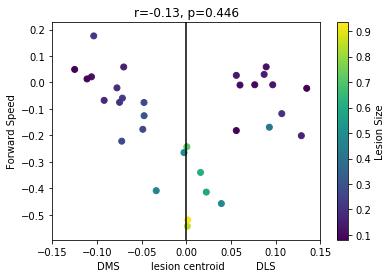

In [146]:
if "__file__" not in dir():
    cm = plt.cm.get_cmap('viridis')
    ax=plt.subplot(111)
    sc=ax.scatter(loc,behav,c=size,cmap=cm)
    ax.set_ylabel(PerfParamToPlot[0])
    ax.set_xlabel('DMS          lesion centroid          DLS')
    ax.set_title('r='+str(np.corrcoef(behav,loc)[0,1])[:5]+', p='+str(scipy.stats.pearsonr(behav,loc)[1])[:5]);
    ax.axvline(0,color='k');
    ax.set_xlim([-.15,.15])
    cbAx=plt.colorbar(sc,ax=ax);
    cbAx.set_label("Lesion Size")

#     for i, txt in enumerate(animals):
#         ax.annotate(txt[-3:], (loc[i], behav[i]))

### Lesion size vs. behavior for LATE lesion animals

In [ ]:
def late_lesion_size_control(root,PerfParamToPlot,profile1,profile2,Ndays=5):
    """
    loads lesion size and location of animals and returns corresponding 
    behavioral measures for those animals
    use for late lesion animals
    """
    animalList=event_detect(root,profile1,profile2)[1].keys()
#     allFiles=HistologyExcel.read_all('/NAS02')

    size=[]
    loc=[]
    behav=[]
    animals=[]
    for animal in animalList:
        try:
            i=HistologyExcel('/NAS02',animal)
        except Exception as e:
            logging.warning(repr(e))
            continue
        
        res1=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile1,
                                stop_date='',redoPreprocess=False,
                                redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][-Ndays:]
        
        res2=plot_learningCurves(root,animal=animal,PerfParamToPlot=PerfParamToPlot,profile=profile2,
                                stop_date='',redoPreprocess=False,
                                redoStat=False,override=False,plot=False,PrintWarning=False)[PerfParamToPlot[0]][:Ndays]


        try:
            t1=(np.nanmedian(res2)-np.nanmedian(res1))/np.nanmedian(res1)
            t2=i.lesion_location()
            t3=i.lesion_size()
        except Exception as e:
            logging.warning(repr(e))
            continue
        behav.append(t1)
        loc.append(t2)
        size.append(t3)
        animals.append(animal)
    
    return behav, loc, size, animals    

In [148]:
if "__file__" not in dir():
    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control','Control-AfterBreak','Control-Late-NoTimeout-BackToTimeout',
                    'Control-NoTimeout-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DMS','Late-Lesion_DLS','Late-Lesion_DS']
             }
    
    _,sessionDic=event_detect(root,profile1,profile2)
    
    PerfParamToPlot =["median entrance time (sec)","percentile entrance time","% good trials",
                      'standard deviation of entrance time',"% good trials on last 40",
                      "Trajectory Correlation","Mean Pairwise RMSE","Forward Speed Vs TreadmillSpeed",
                      "Tortuosity","Run Distance","Delivered Reward Ratio","mean entrance time (sec)"]

    PerfParamToPlot=['Forward Speed']
    
    profile={'Type':'Good'}#AnimalProfile
    # this is where you define a list of functions you want to run on your data (usually, don't touch!)
    plotFunctionList=[]

    
    Behav, Loc, Size, Animals=late_lesion_size_control(root,PerfParamToPlot,profile1,profile2,Ndays=5)

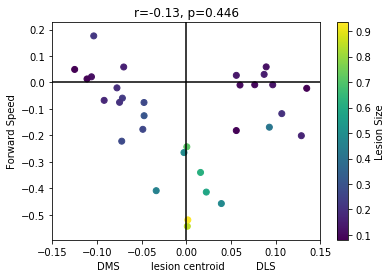

In [149]:
if "__file__" not in dir():
    cm = plt.cm.get_cmap('viridis')
    ax=plt.subplot(111)
    sc=ax.scatter(Loc,Behav,c=Size,cmap=cm)
    ax.set_ylabel(PerfParamToPlot[0])
    ax.set_xlabel('DMS          lesion centroid          DLS')
    ax.set_title('r='+str(np.corrcoef(Behav,Loc)[0,1])[:5]+', p='+str(scipy.stats.pearsonr(Behav,Loc)[1])[:5]);
    ax.axvline(0,color='k');
    ax.axhline(0,color='k');
    ax.set_xlim([-.15,.15]);
    cbAx=plt.colorbar(sc,ax=ax);
    cbAx.set_label("Lesion Size");

#     for i, txt in enumerate(animals):
#         ax.annotate(txt[-3:], (loc[i], behav[i]))